In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imbalanced-learn shap lime xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ba3ffcd1661de911aaeb03deea4100a9050be6fb28bbad7e06843099a55dde0f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle

# Import ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lime.lime_tabular import LimeTabularExplainer
from sklearn.tree import export_text


In [ ]:
# Load the dataset (Make sure you upload train.csv in Google Colab)
df = pd.read_csv("/content/drive/MyDrive/train.csv")

# Display first 5 rows
print(df.head())
# Check for missing values
print(df.isnull().sum())


   ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   A8_Score  A9_Score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation Class/ASD  
0        Austria         

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Load dataset (Replace with actual dataset path)
df = pd.read_csv("/content/drive/MyDrive/train.csv")  # Update as needed

# Handle Missing Values **before encoding** to prevent issues with `.mode()`
for col in ["ethnicity", "relation"]:
    if col in df.columns:
        df.loc[:, col] = df[col].fillna(df[col].mode()[0])

# Compute symptom score sum (A1_Score to A10_Score)
symptom_columns = [col for col in df.columns if col.startswith("A") and col.endswith("_Score")]
if symptom_columns:
    df["symptom_score_sum"] = df[symptom_columns].sum(axis=1)
else:
    print("⚠️ Warning: No symptom score columns found!")

# Age Group Binning (Only if 'age' column exists)
if "age" in df.columns:
    bins = [0, 18, 40, 100]
    labels = ["child", "adult", "senior"]
    df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)
else:
    print("⚠️ Warning: 'age' column not found, skipping age binning.")

# **Ensure categorical columns exist before encoding**
categorical_cols = ["gender", "ethnicity", "jaundice", "austim",
                    "contry_of_res", "used_app_before", "relation", "age_group"]

# Fix potential typo: 'contry_of_res' -> 'country_of_res'
if "country_of_res" in df.columns:
    categorical_cols = [col if col != "contry_of_res" else "country_of_res" for col in categorical_cols]

existing_categorical_cols = [col for col in categorical_cols if col in df.columns]

if existing_categorical_cols:
    df = pd.get_dummies(df, columns=existing_categorical_cols, drop_first=True)
else:
    print("⚠️ Warning: No categorical columns found for encoding!")

# **Scale numerical features**
scaler = StandardScaler()
numerical_features = ["age", "result", "symptom_score_sum"]

# Ensure numerical features exist before scaling
existing_numerical_features = [col for col in numerical_features if col in df.columns]

if existing_numerical_features:
    df[existing_numerical_features] = scaler.fit_transform(df[existing_numerical_features])
else:
    print("⚠️ Warning: No numerical features found for scaling!")

# Save the scaler for future use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Print final results
print("\n✅ Data preprocessing completed successfully!")
print(f"🔹 Final dataset shape: {df.shape}")
print(f"🔹 Columns after processing: {list(df.columns)}")



✅ Data preprocessing completed successfully!
🔹 Final dataset shape: (800, 93)
🔹 Columns after processing: ['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result', 'age_desc', 'Class/ASD', 'symptom_score_sum', 'gender_m', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Latino', 'ethnicity_Middle Eastern ', 'ethnicity_Others', 'ethnicity_Pasifika', 'ethnicity_South Asian', 'ethnicity_Turkish', 'ethnicity_White-European', 'ethnicity_others', 'jaundice_yes', 'austim_yes', 'contry_of_res_AmericanSamoa', 'contry_of_res_Angola', 'contry_of_res_Argentina', 'contry_of_res_Armenia', 'contry_of_res_Aruba', 'contry_of_res_Australia', 'contry_of_res_Austria', 'contry_of_res_Azerbaijan', 'contry_of_res_Bahamas', 'contry_of_res_Bangladesh', 'contry_of_res_Belgium', 'contry_of_res_Bolivia', 'contry_of_res_Brazil', 'contry_of_res_Burundi', 'contry_of_res_Canada', 'contry_of_res_China', 'contr

In [ ]:
print(df.columns)

Index(['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
       'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'result', 'age_desc', 'Class/ASD', 'symptom_score_sum', 'gender_m',
       'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic',
       'ethnicity_Latino', 'ethnicity_Middle Eastern ', 'ethnicity_Others',
       'ethnicity_Pasifika', 'ethnicity_South Asian', 'ethnicity_Turkish',
       'ethnicity_White-European', 'ethnicity_others', 'jaundice_yes',
       'austim_yes', 'contry_of_res_AmericanSamoa', 'contry_of_res_Angola',
       'contry_of_res_Argentina', 'contry_of_res_Armenia',
       'contry_of_res_Aruba', 'contry_of_res_Australia',
       'contry_of_res_Austria', 'contry_of_res_Azerbaijan',
       'contry_of_res_Bahamas', 'contry_of_res_Bangladesh',
       'contry_of_res_Belgium', 'contry_of_res_Bolivia',
       'contry_of_res_Brazil', 'contry_of_res_Burundi', 'contry_of_res_Canada',
       'contry_of_res_China', 'contry_o

In [ ]:
# Define Features (X) and Target (y)
X = df.drop(columns=["Class/ASD", "age_desc", "ID"])
y = df["Class/ASD"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [ ]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model Performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.94140625
Confusion Matrix:
 [[115  10]
 [  5 126]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       125
           1       0.93      0.96      0.94       131

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



In [ ]:
# Define hyperparameters grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Perform GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Select Best Model
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate Best Model
y_pred_best_rf = best_rf_model.predict(X_test)
print("Best RF Model Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Best RF Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
print("Best RF Classification Report:\n", classification_report(y_test, y_pred_best_rf))


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF Model Accuracy: 0.92578125
Best RF Confusion Matrix:
 [[113  12]
 [  7 124]]
Best RF Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       125
           1       0.91      0.95      0.93       131

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



Feature Importances:
symptom_score_sum: 0.1369
ethnicity_White-European: 0.0941
result: 0.0895
A4_Score: 0.0717
A9_Score: 0.0555
age: 0.0551
A6_Score: 0.0531
contry_of_res_United States: 0.0502
A3_Score: 0.0375
A7_Score: 0.0352
A5_Score: 0.0328
A2_Score: 0.0275
austim_yes: 0.0261
A8_Score: 0.0202
A10_Score: 0.0170
A1_Score: 0.0163
jaundice_yes: 0.0143
gender_m: 0.0132
age_group_adult: 0.0109
contry_of_res_United Kingdom: 0.0105
age_group_senior: 0.0089
contry_of_res_India: 0.0083
contry_of_res_Australia: 0.0061
used_app_before_yes: 0.0059
contry_of_res_Canada: 0.0056
relation_Parent: 0.0051
contry_of_res_Netherlands: 0.0051
ethnicity_Middle Eastern : 0.0050
contry_of_res_New Zealand: 0.0045
ethnicity_Pasifika: 0.0043
contry_of_res_France: 0.0041
ethnicity_South Asian: 0.0040
relation_Self: 0.0039
contry_of_res_Ethiopia: 0.0031
ethnicity_Asian: 0.0030
contry_of_res_Azerbaijan: 0.0030
ethnicity_Black: 0.0029
ethnicity_Hispanic: 0.0025
contry_of_res_Spain: 0.0025
ethnicity_Latino: 0.0024


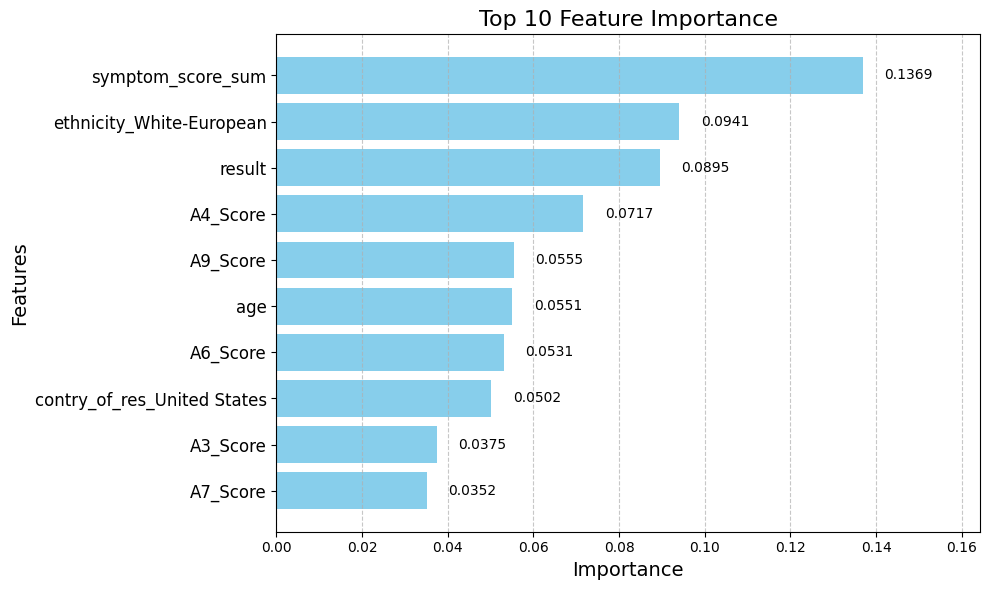

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices in descending order of importance

# Debugging: Print feature importance values
print("Feature Importances:")
for feature, importance in zip(X_train.columns[indices], importances[indices]):
    print(f"{feature}: {importance:.4f}")

# Plot only the top N features for better readability
top_n = 10  # Adjust this value as needed
plt.figure(figsize=(10, 6))  # Adjust figure size
plt.title(f"Top {top_n} Feature Importance", fontsize=16)
bars = plt.barh(range(top_n), importances[indices][:top_n], align="center", color="skyblue")
plt.yticks(range(top_n), [X_train.columns[i] for i in indices[:top_n]], fontsize=12)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Add gridlines for better readability

# Add importance values on the bars
for i, v in enumerate(importances[indices][:top_n]):
    plt.text(v + 0.005, i, f"{v:.4f}", color="black", fontsize=10, va="center")

# Adjust x-axis limits if needed
plt.xlim(0, max(importances[indices][:top_n]) * 1.2)  # Add 20% padding to the x-axis

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# XGBoost Predictions & Evaluation
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.89453125
XGBoost Confusion Matrix:
 [[111  14]
 [ 13 118]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       125
           1       0.89      0.90      0.90       131

    accuracy                           0.89       256
   macro avg       0.89      0.89      0.89       256
weighted avg       0.89      0.89      0.89       256



In [ ]:
cv_scores = cross_val_score(best_rf_model, X_res, y_res, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Cross-Validation Scores: [0.84765625 0.96875    0.94921875 0.9254902  0.94901961]
Mean CV Score: 0.9280269607843138


Shape of X_test: (256, 90)
Shape of shap_values: [(90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 2), (90, 

<Figure size 1400x1000 with 0 Axes>

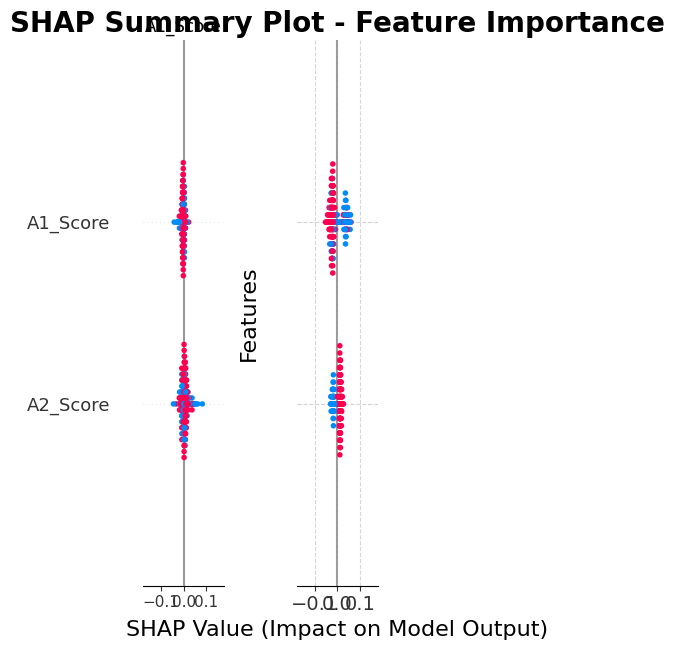

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP Explainer
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

# Debugging: Check SHAP shapes
print("Shape of X_test:", X_test.shape)
print("Shape of shap_values:", [sv.shape for sv in shap_values])

# Select SHAP values for correct class (binary classification)
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]  # Use class index 1 for binary classification
else:
    shap_values_to_use = shap_values  # Use directly for regression or single-class output

# 🔹 Increase figure size for better visibility
plt.figure(figsize=(14, 10))

# 🔹 Use "violin" plot for improved SHAP visualization
shap.summary_plot(
    shap_values_to_use,
    X_test,
    feature_names=X_test.columns,
    plot_type="violin",  # Improved plot type for clearer distributions
    show=False
)

# 🔹 Customize the plot for readability
plt.title("SHAP Summary Plot - Feature Importance", fontsize=20, fontweight="bold")
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0)  # Rotate feature names if needed
plt.grid(True, linestyle="--", alpha=0.5)  # Add light grid for clarity
plt.tight_layout()  # Prevent overlapping elements

# Show the improved plot
plt.show()


In [ ]:
for i, sv in enumerate(shap_values):
    print(f"Class {i}: {sv.shape}")


Class 0: (90, 2)
Class 1: (90, 2)
Class 2: (90, 2)
Class 3: (90, 2)
Class 4: (90, 2)
Class 5: (90, 2)
Class 6: (90, 2)
Class 7: (90, 2)
Class 8: (90, 2)
Class 9: (90, 2)
Class 10: (90, 2)
Class 11: (90, 2)
Class 12: (90, 2)
Class 13: (90, 2)
Class 14: (90, 2)
Class 15: (90, 2)
Class 16: (90, 2)
Class 17: (90, 2)
Class 18: (90, 2)
Class 19: (90, 2)
Class 20: (90, 2)
Class 21: (90, 2)
Class 22: (90, 2)
Class 23: (90, 2)
Class 24: (90, 2)
Class 25: (90, 2)
Class 26: (90, 2)
Class 27: (90, 2)
Class 28: (90, 2)
Class 29: (90, 2)
Class 30: (90, 2)
Class 31: (90, 2)
Class 32: (90, 2)
Class 33: (90, 2)
Class 34: (90, 2)
Class 35: (90, 2)
Class 36: (90, 2)
Class 37: (90, 2)
Class 38: (90, 2)
Class 39: (90, 2)
Class 40: (90, 2)
Class 41: (90, 2)
Class 42: (90, 2)
Class 43: (90, 2)
Class 44: (90, 2)
Class 45: (90, 2)
Class 46: (90, 2)
Class 47: (90, 2)
Class 48: (90, 2)
Class 49: (90, 2)
Class 50: (90, 2)
Class 51: (90, 2)
Class 52: (90, 2)
Class 53: (90, 2)
Class 54: (90, 2)
Class 55: (90, 2)
Cl

In [ ]:
print(len(shap_values), shap_values[0].shape, X_test.shape)


256 (90, 2) (256, 90)


In [ ]:
import numpy as np
import shap

# Compute SHAP values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

# Print structure of SHAP values
print(f"Type of shap_values: {type(shap_values)}")
print(f"Length of shap_values: {len(shap_values)}")

# If it's a list, print details of each element
if isinstance(shap_values, list):
    for i, sv in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]: {np.array(sv).shape}")
print(f"Shape of shap_values: {shap_values.shape}")  # Add this debug line



Type of shap_values: <class 'numpy.ndarray'>
Length of shap_values: 256
Shape of shap_values: (256, 90, 2)


In [ ]:
print(X_train.shape)  # Should be (n_samples, 90)
print(X_test.shape)   # Should be (n_samples, 90)
print(X_train.columns)

(1022, 90)
(256, 90)
Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result',
       'symptom_score_sum', 'gender_m', 'ethnicity_Asian', 'ethnicity_Black',
       'ethnicity_Hispanic', 'ethnicity_Latino', 'ethnicity_Middle Eastern ',
       'ethnicity_Others', 'ethnicity_Pasifika', 'ethnicity_South Asian',
       'ethnicity_Turkish', 'ethnicity_White-European', 'ethnicity_others',
       'jaundice_yes', 'austim_yes', 'contry_of_res_AmericanSamoa',
       'contry_of_res_Angola', 'contry_of_res_Argentina',
       'contry_of_res_Armenia', 'contry_of_res_Aruba',
       'contry_of_res_Australia', 'contry_of_res_Austria',
       'contry_of_res_Azerbaijan', 'contry_of_res_Bahamas',
       'contry_of_res_Bangladesh', 'contry_of_res_Belgium',
       'contry_of_res_Bolivia', 'contry_of_res_Brazil',
       'contry_of_res_Burundi', 'contry_of_res_Canada', 'contry_of_res_China',
       'contry_of_res_Cypr

In [ ]:
import numpy as np

# Select SHAP values for class 1 (index 1)
selected_shap_values = np.array([shap[:, 1] for shap in shap_values])

# Ensure shape matches X_test
selected_shap_values = selected_shap_values.reshape(X_test.shape)

print("New SHAP values shape:", selected_shap_values.shape)


New SHAP values shape: (256, 90)


In [ ]:
print(f"Model input shape: {best_rf_model.n_features_in_}")  # Check model input shape
print(f"X_test shape: {X_test.shape}")  # Ensure they align


Model input shape: 90
X_test shape: (256, 90)


In [ ]:
# Recreate SHAP explainer with the correct data
explainer = shap.TreeExplainer(best_rf_model)

# Compute SHAP values for all samples in X_test
shap_values = explainer.shap_values(X_test)

# Debug: Check shapes again
print(f"X_test shape: {X_test.shape}")
for i, sv in enumerate(shap_values):
    print(f"Shape of shap_values[{i}]: {sv.shape}")


X_test shape: (256, 90)
Shape of shap_values[0]: (90, 2)
Shape of shap_values[1]: (90, 2)
Shape of shap_values[2]: (90, 2)
Shape of shap_values[3]: (90, 2)
Shape of shap_values[4]: (90, 2)
Shape of shap_values[5]: (90, 2)
Shape of shap_values[6]: (90, 2)
Shape of shap_values[7]: (90, 2)
Shape of shap_values[8]: (90, 2)
Shape of shap_values[9]: (90, 2)
Shape of shap_values[10]: (90, 2)
Shape of shap_values[11]: (90, 2)
Shape of shap_values[12]: (90, 2)
Shape of shap_values[13]: (90, 2)
Shape of shap_values[14]: (90, 2)
Shape of shap_values[15]: (90, 2)
Shape of shap_values[16]: (90, 2)
Shape of shap_values[17]: (90, 2)
Shape of shap_values[18]: (90, 2)
Shape of shap_values[19]: (90, 2)
Shape of shap_values[20]: (90, 2)
Shape of shap_values[21]: (90, 2)
Shape of shap_values[22]: (90, 2)
Shape of shap_values[23]: (90, 2)
Shape of shap_values[24]: (90, 2)
Shape of shap_values[25]: (90, 2)
Shape of shap_values[26]: (90, 2)
Shape of shap_values[27]: (90, 2)
Shape of shap_values[28]: (90, 2)


In [ ]:
import pandas as pd

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

# Set pandas to display all rows (if needed)
pd.set_option('display.max_rows', None)

# Now print the instance
print("Instance used for explanation:")
print(X_test.iloc[1])
# LIME Explainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=["No ASD", "ASD"], discretize_continuous=True)

# Choose a random instance to explain
i = 1
exp = lime_explainer.explain_instance(X_test.values[i], best_rf_model.predict_proba)
exp.show_in_notebook()


Instance used for explanation:
A1_Score                                     1
A2_Score                                     1
A3_Score                                     1
A4_Score                                     1
A5_Score                                     1
A6_Score                                     1
A7_Score                                     1
A8_Score                                     1
A9_Score                                     1
A10_Score                                    1
age                                   1.391896
result                                0.871658
symptom_score_sum                       1.5254
gender_m                                 False
ethnicity_Asian                          False
ethnicity_Black                          False
ethnicity_Hispanic                       False
ethnicity_Latino                         False
ethnicity_Middle Eastern                 False
ethnicity_Others                         False
ethnicity_Pasifika           

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Save the trained model
with open('/content/autism_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# Load the trained model and scaler
with open('/content/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('/content/autism_model.pkl', 'rb') as f:#7otttttttt autism_model
    best_rf_model = pickle.load(f)

# Define the original feature names (before one-hot encoding)
original_features = [
    'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
    'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
    'age', 'gender', 'ethnicity', 'jaundice', 'austim',
    'contry_of_res', 'used_app_before', 'relation'
]

# Define categorical columns to be one-hot encoded
categorical_columns = ['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'relation']

# Function to collect user input
def collect_user_input():
    input_data = {}
    print("Please enter the following details:")

    for i in range(1, 11):
        input_data[f'A{i}_Score'] = int(input(f"A{i}_Score (1 or 0): "))

    input_data['age'] = int(input("Age: "))
    input_data['gender'] = input("Gender (M or F): ").upper()
    input_data['ethnicity'] = input("Ethnicity (e.g., White-European, Asian, etc.): ")
    input_data['jaundice'] = input("Jaundice (yes or no): ").lower()
    input_data['austim'] = input("Autism (yes or no): ").lower()
    input_data['contry_of_res'] = input("Country of Residence: ")
    input_data['used_app_before'] = input("Used App Before (yes or no): ").lower()
    input_data['relation'] = input("Relation (e.g., Self, Parent, etc.): ")

    return input_data

# Collect user input
input_data = collect_user_input()

# Convert input data to a DataFrame
input_df = pd.DataFrame([input_data])

# Calculate symptom_score_sum and result
input_df['symptom_score_sum'] = input_df[[f'A{i}_Score' for i in range(1, 11)]].sum(axis=1)
input_df['result'] = input_df['symptom_score_sum']  # Ensure 'result' column exists

# Determine age group
def get_age_group(age):
    if age < 18:
        return 'child'
    elif 18 <= age < 40:
        return 'adult'
    else:
        return 'senior'

input_df['age_group'] = input_df['age'].apply(get_age_group)

# One-hot encode categorical variables
input_df = pd.get_dummies(input_df, columns=categorical_columns + ['age_group'])

# Load the feature names used during training
feature_names = [
    'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
    'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
    'age', 'gender_M', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic',
    'ethnicity_Latino', 'ethnicity_Middle Eastern', 'ethnicity_Others',
    'ethnicity_Pasifika', 'ethnicity_South Asian', 'ethnicity_Turkish',
    'ethnicity_White-European', 'ethnicity_others', 'jaundice_yes', 'austim_yes',
    'contry_of_res_Austria', 'contry_of_res_India', 'contry_of_res_United States',
    'used_app_before_yes', 'relation_Health care professional',
    'relation_Others', 'relation_Parent', 'relation_Relative', 'relation_Self',
    'age_group_child', 'age_group_adult', 'age_group_senior', 'symptom_score_sum', 'result'
]

# Get expected features from the trained model
expected_features = best_rf_model.feature_names_in_

# Ensure all expected columns are present (fill missing ones with 0)
for col in expected_features:
    if col not in input_df.columns:
        input_df[col] = 0

# Remove extra columns & reorder to match training
input_df = input_df[expected_features]

# Now make the prediction
prediction = best_rf_model.predict(input_df)
prediction_proba = best_rf_model.predict_proba(input_df)


# Display the result
if prediction[0] == 1:
    print("Prediction: ASD (Autism Spectrum Disorder)")
else:
    print("Prediction: No ASD")

print(f"Prediction Probability: {prediction_proba[0]}")


Please enter the following details:


KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install flask pandas numpy scikit-learn
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 22 packages in 2s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [ ]:
from flask import Flask, request, render_template
import threading
import pandas as pd
import numpy as np
import pickle

app = Flask(__name__, template_folder="/content/drive/MyDrive/Colab Notebooks/templates")  # Ensure HTML files are in this folder

# Load the trained model and scaler
with open("/content/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("/content/autism_model.pkl", "rb") as f:
    model = pickle.load(f)

@app.route("/", methods=["GET", "POST"])
def autism_detection():
    prediction = None
    if request.method == "POST":
        input_data = {key: request.form[key] for key in request.form.keys()}
        input_data = {k: int(v) if v.isdigit() else v for k, v in input_data.items()}

        # Convert to DataFrame
        input_df = pd.DataFrame([input_data])
        input_df["symptom_score_sum"] = sum([input_data[f"A{i}_Score"] for i in range(1, 11)])
        input_df["result"] = input_df["symptom_score_sum"]
        input_df["gender_M"] = 1 if input_df["gender"].iloc[0] == "Male" else 0
        input_df["jaundice_yes"] = 1 if input_df["jaundice"].iloc[0] == "yes" else 0
        input_df["austim_yes"] = 1 if input_df["austim"].iloc[0] == "yes" else 0
        input_df["used_app_before_yes"] = 1 if input_df["used_app_before"].iloc[0] == "yes" else 0

        # Age group binning
        age = input_df["age"].iloc[0]
        input_df["age_group_child"] = 1 if age < 18 else 0
        input_df["age_group_adult"] = 1 if 18 <= age < 40 else 0
        input_df["age_group_senior"] = 1 if age >= 40 else 0

        # Ensure all expected columns exist
        expected_features = model.feature_names_in_
        for col in expected_features:
            if col not in input_df.columns:
                input_df[col] = 0
        input_df = input_df[expected_features]

        # Scale numerical features
        input_df[["age", "result", "symptom_score_sum"]] = scaler.transform(input_df[["age", "result", "symptom_score_sum"]])

        # Predict
        prediction = model.predict(input_df)[0]

    return render_template("autism_detection.html", prediction=prediction)

@app.route("/data_collection", methods=["POST"])
def data_collection():
    diagnosis = request.form["diagnosis"]
    return render_template("data_collection_success.html")

# Run Flask in a separate thread
def run():
    app.run(host="0.0.0.0", port=5005)

threading.Thread(target=run).start()


 * Serving Flask app '__main__'
 * Debug mode: off


In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5005)"))


https://e2s5iraazgo-496ff2e9c6d22116-5005-colab.googleusercontent.com/


In [ ]:
!pip install pyngrok
from pyngrok import ngrok

port = 5005
public_url = ngrok.connect(port).public_url
print(f"Public URL: {public_url}")


Public URL: https://c976-34-16-163-96.ngrok-free.app


In [ ]:
!ngrok authtoken 2tRjcX9AGHIavKFl1PHMAhjJlSf_78VHuPhMoDAfVyySyUPrW


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
